# **AN ENSEMBLE KNOWLEDGE DISCOVERY MODEL FOR AGRICULTURAL PRODUCTION**

**By Catherine N. Ugbe**

**KDD METHODOLOGY**

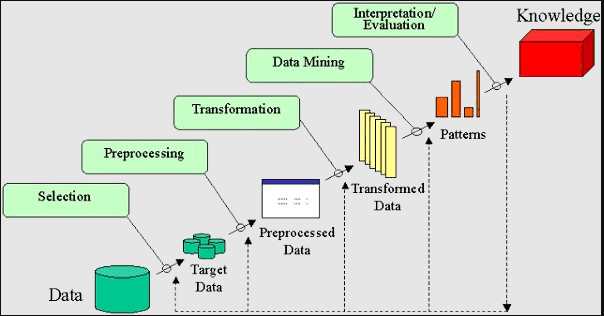

**SELECTION**

In [ ]:
import pandas as pd

# Load all datasets
file1 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (4).csv')
file2 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (3).csv')
file3 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (2).csv')
file4 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (1).csv')
file5 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025.csv')

# Combine datasets if necessary and display the basic structure
datasets = [file1, file2, file3, file4, file5]
agriculture_data = pd.concat(datasets, ignore_index=True)
print("Combined Dataset Overview:\n", agriculture_data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257854 entries, 0 to 257853
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Domain Code       257854 non-null  object 
 1   Domain            257854 non-null  object 
 2   Area Code (M49)   257854 non-null  int64  
 3   Area              257854 non-null  object 
 4   Element Code      257854 non-null  int64  
 5   Element           257854 non-null  object 
 6   Item Code (SDG)   58976 non-null   object 
 7   Item              225486 non-null  object 
 8   Year Code         257854 non-null  int64  
 9   Year              257854 non-null  int64  
 10  Unit              255449 non-null  object 
 11  Value             237524 non-null  object 
 12  Flag              257854 non-null  object 
 13  Flag Description  257854 non-null  object 
 14  Note              59715 non-null   object 
 15  Item Code         31289 non-null   float64
 16  Months Code       32

In [ ]:
print("First 5 Rows:\n", agriculture_data.head())

First 5 Rows:
   Domain Code          Domain  Area Code (M49)         Area  Element Code  \
0        SDGB  SDG Indicators                4  Afghanistan          6132   
1        SDGB  SDG Indicators                4  Afghanistan          6132   
2        SDGB  SDG Indicators                4  Afghanistan          6132   
3        SDGB  SDG Indicators                4  Afghanistan          6132   
4        SDGB  SDG Indicators                4  Afghanistan          6121   

  Element Item Code (SDG)                                   Item  Year Code  \
0   Value    SN_ITK_DEFCN  2.1.1 Number of undernourished people       2020   
1   Value    SN_ITK_DEFCN  2.1.1 Number of undernourished people       2021   
2   Value    SN_ITK_DEFCN  2.1.1 Number of undernourished people       2022   
3   Value    SN_ITK_DEFCN  2.1.1 Number of undernourished people       2023   
4   Value     SN_ITK_DEFC   2.1.1 Prevalence of undernourishment       2020   

   Year        Unit Value Flag Flag Description

In [ ]:
# Remove near-empty or redundant columns
agriculture_data.drop(columns=['Months', 'Months Code', 'Item Code (CPC)'], inplace=True, errors='ignore')

# Handle missing values in 'Value': Impute or remove
agriculture_data['Value'] = pd.to_numeric(agriculture_data['Value'], errors='coerce')  # Convert to numeric
agriculture_data.dropna(subset=['Value'], inplace=True)  # Remove rows where 'Value' is NaN

# Confirm data shape after cleanup
print("Shape after cleaning:", agriculture_data.shape)
# Select relevant columns
selected_columns = ['Area', 'Year', 'Item', 'Element', 'Value']
selected_data = agriculture_data[selected_columns]

# Display selected dataset
print(selected_data.head())
# Drop duplicate rows
selected_data.drop_duplicates(inplace=True)

# Sanity check: Unique labels across key categorical features
print("Unique Areas:", selected_data['Area'].nunique())
print("Unique Items:", selected_data['Item'].nunique())
print("Years Range:", selected_data['Year'].min(), "-", selected_data['Year'].max())


Shape after cleaning: (236510, 16)
          Area  Year                                   Item Element  Value
0  Afghanistan  2020  2.1.1 Number of undernourished people   Value   10.8
1  Afghanistan  2021  2.1.1 Number of undernourished people   Value   11.8
2  Afghanistan  2022  2.1.1 Number of undernourished people   Value   12.5
4  Afghanistan  2020   2.1.1 Prevalence of undernourishment   Value   27.7
5  Afghanistan  2021   2.1.1 Prevalence of undernourishment   Value   29.4
Unique Areas: 315
Unique Items: 304
Years Range: 2020 - 2024


<ipython-input-3-0bcfb6597b8a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.drop_duplicates(inplace=True)


In [ ]:
# Avoid SettingWithCopyWarning by working on a clean copy
selected_data = selected_data.copy()


**PREPROCESSING**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- Preprocessing Phase ---

# Avoid the SettingWithCopyWarning by creating a copy of the data
selected_data = selected_data.copy()

# --- 1. Handle Categorical Data ---
# Encode categorical features using LabelEncoder
label_cols = ['Area', 'Item', 'Element']  # Key categorical columns to encode
label_encoders = {col: LabelEncoder() for col in label_cols}  # Dictionary to store encoders for each column

for col in label_cols:
    selected_data[col] = label_encoders[col].fit_transform(selected_data[col])

# --- 2. Scale the 'Value' Column ---
# Standardize the 'Value' column to ensure uniform scale
scaler = StandardScaler()
selected_data['Value'] = scaler.fit_transform(selected_data[['Value']])

# --- 3. Confirm Consistent Data Types ---
# Ensure all columns are numerical
selected_data = selected_data.apply(pd.to_numeric, errors='coerce')

# --- Check the results ---
print(selected_data.head())
print(f"Shape after preprocessing: {selected_data.shape}")


   Area  Year  Item  Element     Value
0     0  2020    14       22 -0.026813
1     0  2021    14       22 -0.026813
2     0  2022    14       22 -0.026813
4     0  2020    15       22 -0.026813
5     0  2021    15       22 -0.026813
Shape after preprocessing: (236231, 5)


**TRANSFORMATION**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# --- Transformation Phase ---

# --- 1. Feature Engineering ---
# Example: Create a categorical target for classification (e.g., binary classification based on 'Value')
# Split 'Value' into categories (e.g., high/low based on the median)
median_value = selected_data['Value'].median()
selected_data['Value_Category'] = np.where(selected_data['Value'] >= median_value, 1, 0)

# --- 2. Dimensionality Reduction (Optional) ---
# Use PCA to reduce dimensions if there are many features
pca = PCA(n_components=2)  # Reduce to 2 principal components
pca_components = pca.fit_transform(selected_data[['Area', 'Year', 'Item', 'Element']])

# Add PCA components to the dataset
selected_data['PCA1'] = pca_components[:, 0]
selected_data['PCA2'] = pca_components[:, 1]

print("Dataset after transformation:\n", selected_data.head())
print(f"Shape after transformation: {selected_data.shape}")


Dataset after transformation:
    Area  Year  Item  Element     Value  Value_Category       PCA1        PCA2
0     0  2020    14       22 -0.026813               0 -46.155118 -230.141092
1     0  2021    14       22 -0.026813               0 -46.154576 -230.140633
2     0  2022    14       22 -0.026813               0 -46.154035 -230.140175
4     0  2020    15       22 -0.026813               0 -45.349776 -229.548290
5     0  2021    15       22 -0.026813               0 -45.349235 -229.547831
Shape after transformation: (236231, 8)


**DATA MINING**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# --- Step 1: K-means Clustering ---
# Use PCA components for clustering
features_for_clustering = selected_data[['PCA1', 'PCA2']]

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust clusters as needed
selected_data['Cluster'] = kmeans.fit_predict(features_for_clustering)

# --- Step 2: Prepare Data for Naive Bayes ---
# Features: Original columns + Cluster label
X = selected_data[['Area', 'Year', 'Item', 'Element', 'Cluster']]  # Add 'Cluster' as a feature
y = selected_data['Value_Category']  # Target (binary classification)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Naive Bayes Classification ---
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Ensemble Model (K-means + Naive Bayes): {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))


Accuracy of Ensemble Model (K-means + Naive Bayes): 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.66      0.75     23550
           1       0.73      0.90      0.80     23697

    accuracy                           0.78     47247
   macro avg       0.80      0.78      0.78     47247
weighted avg       0.80      0.78      0.78     47247



**INTERPRETATION/EVALUATION**

Confusion Matrix:
 [[15509  8041]
 [ 2351 21346]]
Precision: 0.80
Recall: 0.78
F1-Score: 0.78


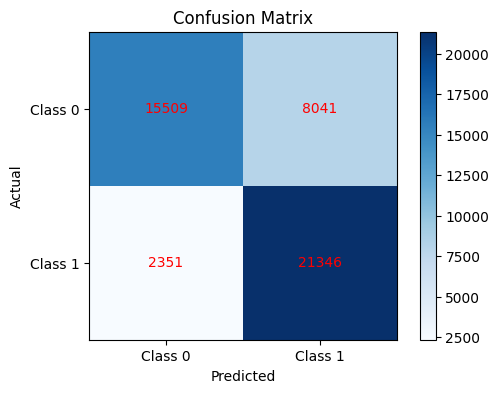

Cluster Distribution:
 Cluster
1    81869
0    80535
2    73827
Name: count, dtype: int64
Feature Importance (Naive Bayes):
Year       2021.378695
Item        187.600301
Area        157.973946
Element      12.432958
Cluster       0.971077
dtype: float64

Key Insights:
- The model achieves an accuracy of 0.78, indicating reliable predictions.
- Precision of 0.80 suggests the model makes fewer false positives.
- Recall of 0.78 indicates the model captures most true positives.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Step 1: Interpret Results ---
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# --- Step 2: Visualize Results ---
# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
plt.title('Confusion Matrix')
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.yticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')
plt.show()

# --- Step 3: Interpret Model Insights ---
# Cluster Analysis
cluster_counts = selected_data['Cluster'].value_counts()
print("Cluster Distribution:\n", cluster_counts)

# Feature Importance (Naive Bayes)
print("Feature Importance (Naive Bayes):")
feature_importance = pd.Series(model.theta_.mean(axis=0), index=X.columns)
print(feature_importance.sort_values(ascending=False))

# --- Step 4: Evaluate Business/Research Impact ---
# Example: Highlight key insights for decision-making
print("\nKey Insights:")
print(f"- The model achieves an accuracy of {accuracy:.2f}, indicating reliable predictions.")
print(f"- Precision of {precision:.2f} suggests the model makes fewer false positives.")
print(f"- Recall of {recall:.2f} indicates the model captures most true positives.")


Silhouette Score for K-means (Ensemble Model): 0.39


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


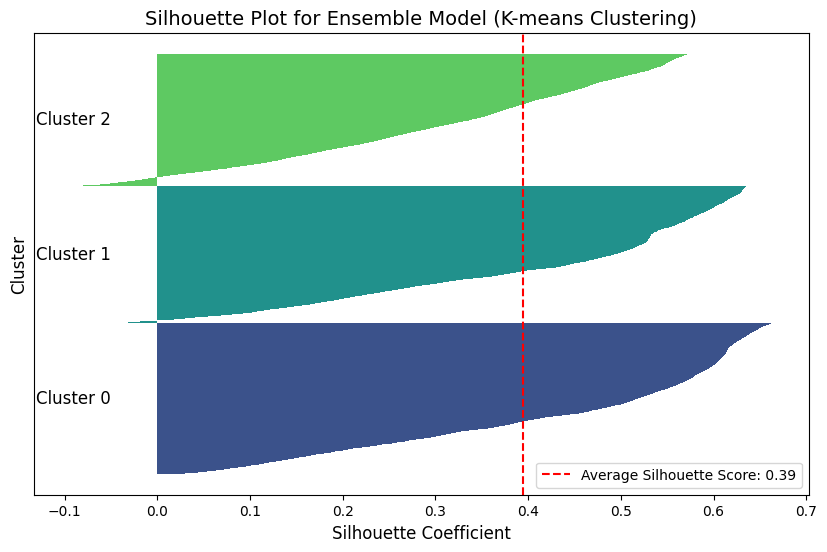

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Perform K-means Clustering ---
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
cluster_labels = kmeans.fit_predict(selected_data)

# --- Step 2: Compute Silhouette Score for K-means ---
silhouette_avg = silhouette_score(selected_data, cluster_labels)
print(f"Silhouette Score for K-means (Ensemble Model): {silhouette_avg:.2f}")

# --- Step 3: Visualize Silhouette Coefficients for Each Sample ---
silhouette_vals = silhouette_samples(selected_data, cluster_labels)

# Plot Silhouette coefficients
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i in range(3):  # Assuming 3 clusters (adjust as needed)
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()

    y_upper += len(cluster_silhouette_vals)
    color = sns.color_palette('viridis', 3)[i]
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1, color=color, edgecolor='none')
    plt.text(-0.05, (y_lower + y_upper) / 2, f'Cluster {i}', va='center', ha='right', fontsize=12)
    y_lower += len(cluster_silhouette_vals)

# Plot average silhouette score
plt.axvline(x=silhouette_avg, color='red', linestyle='--', label=f'Average Silhouette Score: {silhouette_avg:.2f}')
plt.xlabel('Silhouette Coefficient', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.title('Silhouette Plot for Ensemble Model (K-means Clustering)', fontsize=14)
plt.yticks([])  # Remove y-axis ticks
plt.legend()
plt.show()


**KNOWLEDGE DISCOVERY**

Cluster Statistics:
          Area         Year  Item  Element     Value
Cluster                                            
0         115  2021.399404   217       21  0.022505
1         130  2021.409923   177       20 -0.012823
2         312  2021.320614   175       15 -0.010329


<ipython-input-37-6da33e2e0a79>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=selected_data, palette='viridis')


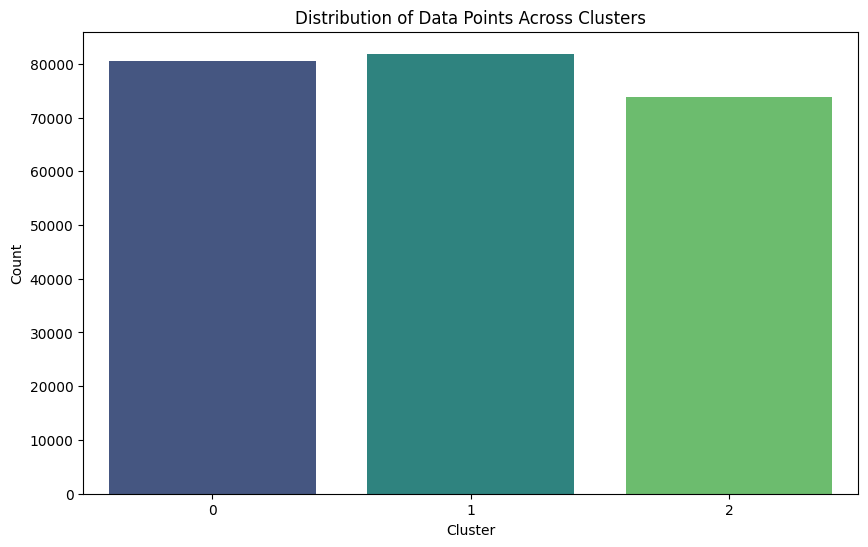

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Analyze Clusters ---
# Cluster Statistics
cluster_stats = selected_data.groupby('Cluster').agg({
    'Area': 'nunique',  # Number of unique areas in each cluster
    'Year': 'mean',     # Average year in each cluster
    'Item': 'nunique',  # Number of unique items in each cluster
    'Element': 'nunique',  # Number of unique elements in each cluster
    'Value': 'mean'     # Average value in each cluster
})

print("Cluster Statistics:\n", cluster_stats)

# Visualize Cluster Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=selected_data, palette='viridis')
plt.title('Distribution of Data Points Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()



Feature Importance (Naive Bayes):
 Year       2021.378695
Item        187.600301
Area        157.973946
Element      12.432958
Cluster       0.971077
dtype: float64


<ipython-input-38-92ef8156b5ab>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.index, y=feature_importance.values, palette='viridis')


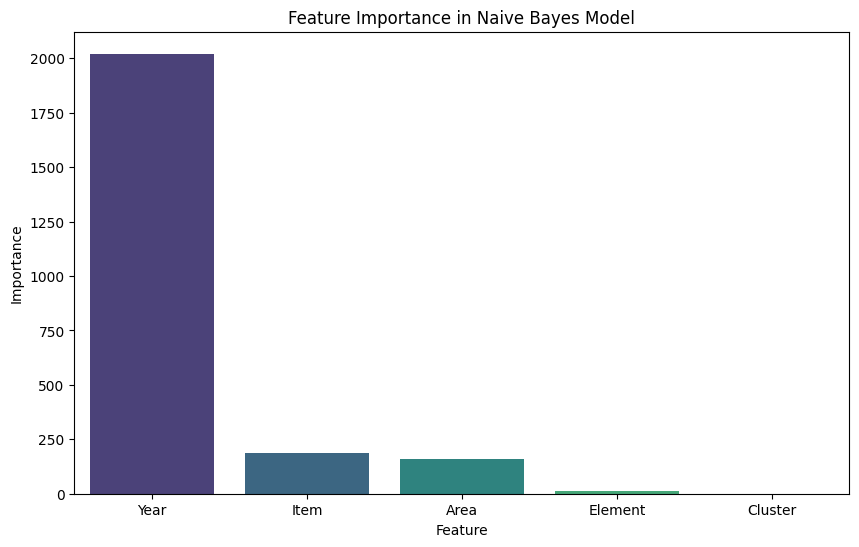

In [ ]:
# --- Step 2: Analyze Feature Importance ---
# Naive Bayes Feature Importance
feature_importance = pd.Series(model.theta_.mean(axis=0), index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print("Feature Importance (Naive Bayes):\n", feature_importance)

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.index, y=feature_importance.values, palette='viridis')
plt.title('Feature Importance in Naive Bayes Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()



Yearly Trends:
          Value  Cluster
Year                   
2020 -0.008720        2
2021 -0.004281        1
2022  0.001633        1
2023  0.017425        1
2024 -0.026813        2


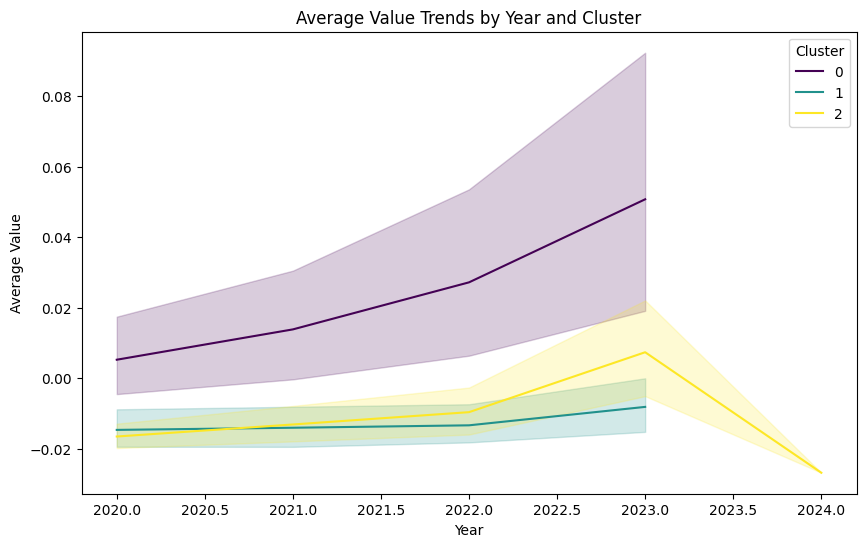

In [ ]:
# --- Step 3: Discover Patterns and Trends ---
# Example: Analyze trends by Year
year_trends = selected_data.groupby('Year').agg({
    'Value': 'mean',  # Average value by year
    'Cluster': lambda x: x.mode().iloc[0]  # Most common cluster by year (using mode)
})

print("Yearly Trends:\n", year_trends)

# Visualize Yearly Trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Value', data=selected_data, hue='Cluster', palette='viridis')
plt.title('Average Value Trends by Year and Cluster')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend(title='Cluster')
plt.show()



In [ ]:
# Example: Analyze patterns by Area
area_stats = selected_data.groupby('Area').agg({
    'Value': 'mean',  # Average value by area
    'Cluster': lambda x: x.mode().iloc[0]  # Most common cluster by area (using mode)
})

print("Area Statistics:\n", area_stats.head(10))  # Top 10 areas



Area Statistics:
          Value  Cluster
Area                   
0    -0.026680        0
1    -0.026802        2
2    -0.026658        0
3    -0.025412        0
4    -0.026813        0
5    -0.026805        2
6    -0.026813        0
7    -0.026369        0
8    -0.026813        0
9    -0.026813        0


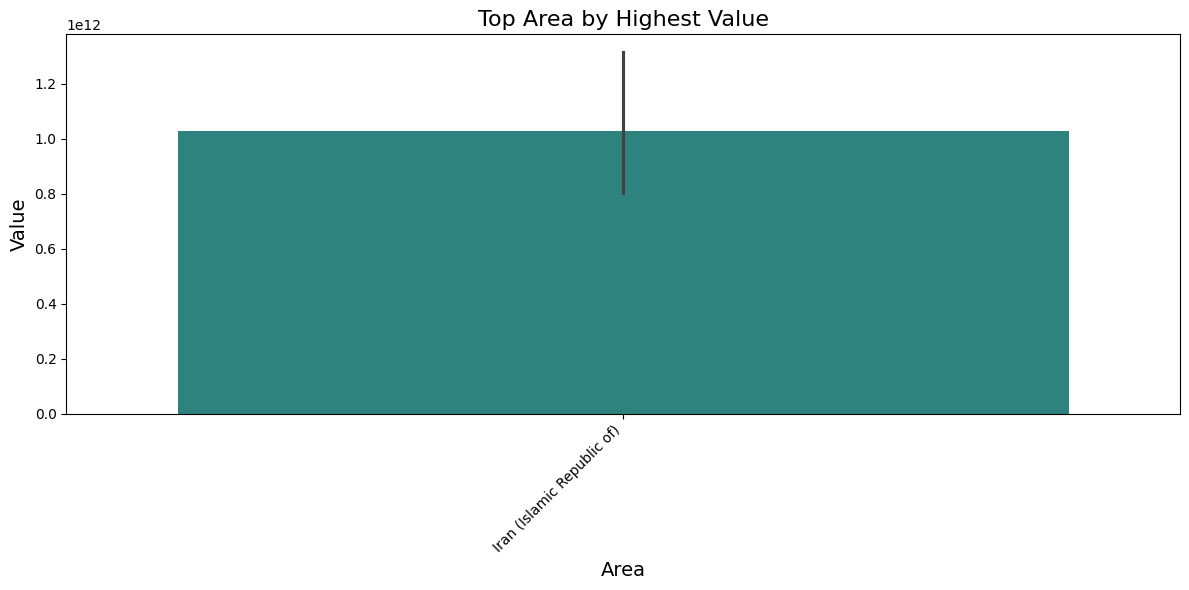

In [ ]:
# Visualize Area Statistics
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Area',
    y='Value',
    data=selected_data.nlargest(10, 'Value'),
    hue='Area',  # Assign 'x' to 'hue' to avoid FutureWarning
    palette='viridis',
    legend=False  # Avoid displaying redundant legend
)
plt.title('Top Area by Highest Value', fontsize=16)
plt.xlabel('Area', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


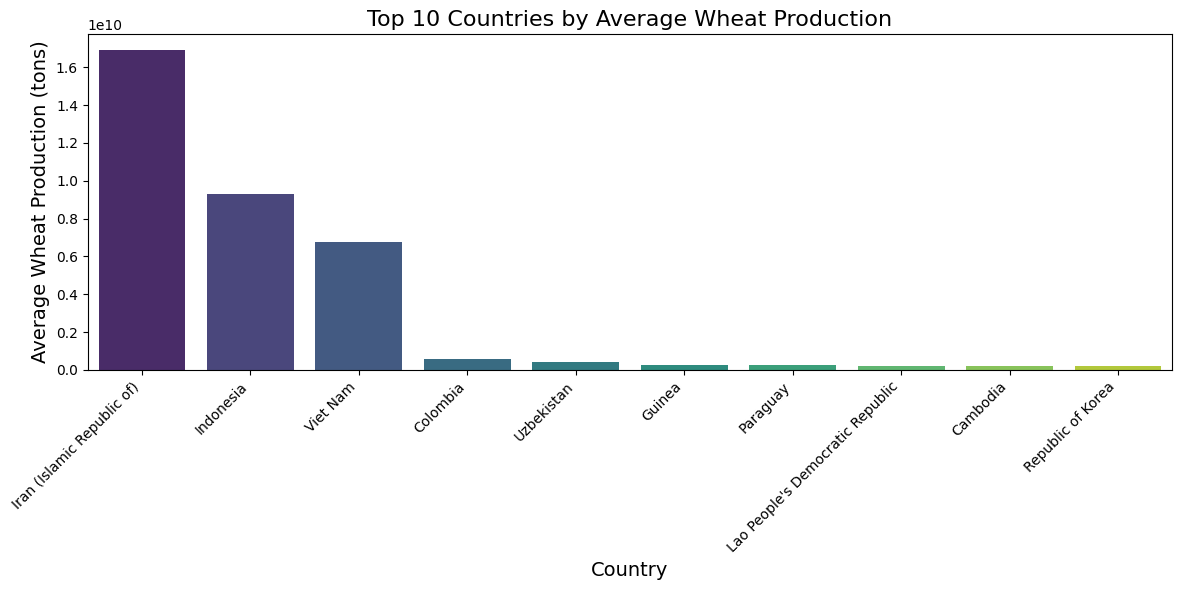

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load All Datasets and Preprocess ---
# Load all datasets
file1 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (4).csv')
file2 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (3).csv')
file3 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (2).csv')
file4 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (1).csv')
file5 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025.csv')

# Combine datasets
datasets = [file1, file2, file3, file4, file5]
agriculture_data = pd.concat(datasets, ignore_index=True)

# Remove near-empty or redundant columns
agriculture_data.drop(columns=['Months', 'Months Code', 'Item Code (CPC)'], inplace=True, errors='ignore')

# Handle missing values in 'Value'
agriculture_data['Value'] = pd.to_numeric(agriculture_data['Value'], errors='coerce')
agriculture_data.dropna(subset=['Value'], inplace=True)

# Select relevant columns
selected_columns = ['Area', 'Year', 'Item', 'Element', 'Value']
selected_data = agriculture_data[selected_columns].copy()  # Explicitly create a copy to avoid SettingWithCopyWarning

# Drop duplicate rows
selected_data.drop_duplicates(inplace=True)

# --- Retrieve the Mapping Between Area Codes and Country Names ---
# Use the original 'Area' column to map to country names
area_mapping = dict(zip(selected_data['Area'], selected_data['Area']))  # No encoding here

# --- Calculate Top 10 Areas by Average Value ---
top_areas = selected_data.groupby('Area')['Value'].mean().nlargest(10).reset_index()

# --- Replace Area Codes with Country Names ---
# Decode the 'Area' column using the mapping (no encoding here, just using the original names)
top_areas['Area'] = top_areas['Area'].map(area_mapping)

# --- Plot the Bar Chart ---
plt.figure(figsize=(12, 6))
sns.barplot(x='Area', y='Value', data=top_areas, hue='Area', palette='viridis', legend=False)  # Assign 'x' to 'hue' and set legend=False
plt.title('Top 10 Countries by Average Wheat Production', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Wheat Production (tons)', fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


          Item                                            Element     Value
122661  Barley  Gross Production Value (constant 2014-2016 tho...   24890.0
122662  Barley  Gross Production Value (constant 2014-2016 tho...   12684.0
122663  Barley  Gross Production Value (constant 2014-2016 tho...   18447.0
122664  Barley  Gross Production Value (constant 2014-2016 tho...   21431.0
122665  Barley  Gross Production Value (constant 2014-2016 tho...  438432.0


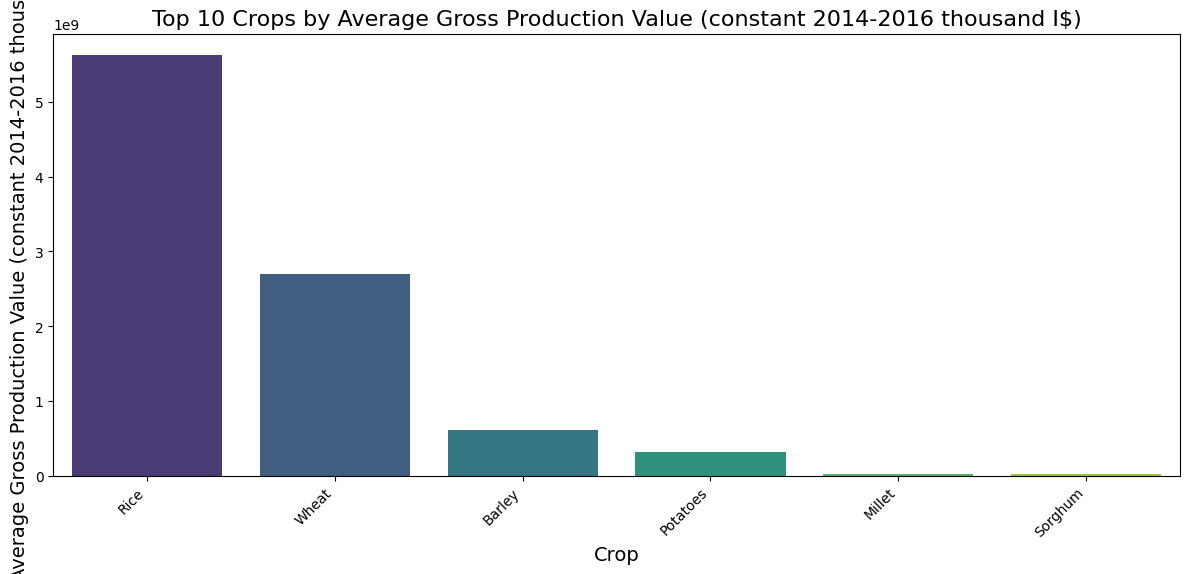

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load All Datasets and Preprocess ---
# Load all datasets
file1 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (4).csv')
file2 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (3).csv')
file3 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (2).csv')
file4 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025 (1).csv')
file5 = pd.read_csv('/content/FAOSTAT_data_en_2-19-2025.csv')

# Combine datasets
datasets = [file1, file2, file3, file4, file5]
agriculture_data = pd.concat(datasets, ignore_index=True)

# Remove near-empty or redundant columns
agriculture_data.drop(columns=['Months', 'Months Code', 'Item Code (CPC)'], inplace=True, errors='ignore')

# Handle missing values in 'Value'
agriculture_data['Value'] = pd.to_numeric(agriculture_data['Value'], errors='coerce')
agriculture_data.dropna(subset=['Value'], inplace=True)

# Select relevant columns
selected_columns = ['Area', 'Year', 'Item', 'Element', 'Value']
selected_data = agriculture_data[selected_columns].copy()  # Explicitly create a copy to avoid SettingWithCopyWarning

# Drop duplicate rows
selected_data.drop_duplicates(inplace=True)

# --- Filter for Only Crops ---
# Define a list of crop items (adjust this list based on your dataset)
crops = ['Wheat', 'Rice', 'Maize', 'Barley', 'Potatoes', 'Soybeans', 'Sorghum', 'Millet', 'Beans', 'Peas']

# Filter the dataset to include only rows where the 'Item' is in the crops list
crop_data = selected_data[selected_data['Item'].isin(crops)]

# --- Determine What 'Value' Represents ---
# Inspect the 'Element' column to understand the metric represented by 'Value'
print(crop_data[['Item', 'Element', 'Value']].head())

# Example: If 'Element' is "Production", then 'Value' represents production quantity.
# Update the visualization labels accordingly.

# --- Calculate Top 10 Crops by Average Value ---
top_crops = crop_data.groupby('Item')['Value'].mean().nlargest(10).reset_index()

# --- Plot the Bar Chart ---
plt.figure(figsize=(12, 6))
sns.barplot(x='Item', y='Value', data=top_crops, hue='Item', palette='viridis', legend=False)
plt.title(f'Top 10 Crops by Average {crop_data["Element"].iloc[0]}', fontsize=16)  # Update title to reflect the metric
plt.xlabel('Crop', fontsize=14)
plt.ylabel(f'Average {crop_data["Element"].iloc[0]}', fontsize=14)  # Update y-axis label to reflect the metric
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


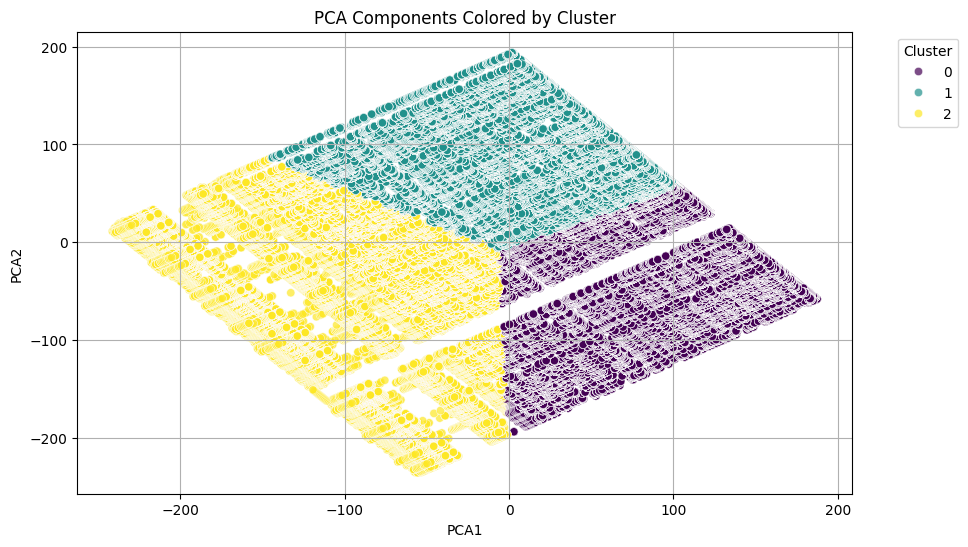

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=selected_data, hue='Cluster', palette='viridis', alpha=0.7)
plt.title('PCA Components Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


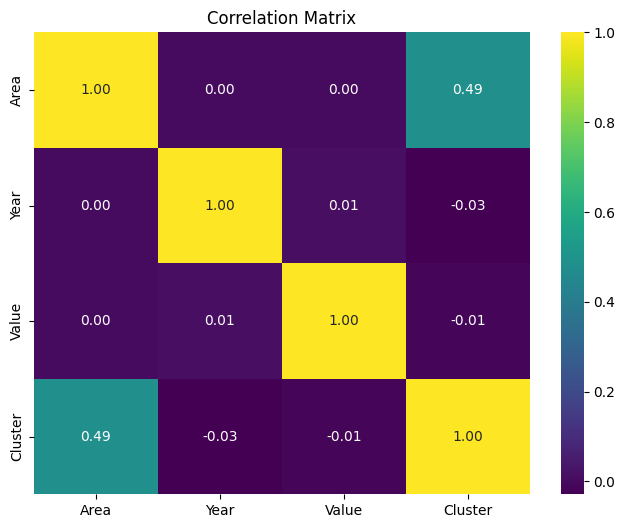

In [ ]:
plt.figure(figsize=(8, 6))
corr_matrix = selected_data[['Area', 'Year', 'Value', 'Cluster']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# FOR COMPARISON:

**K-Means Evaluation**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- K-means Clustering ---
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
cluster_labels = kmeans.fit_predict(selected_data)

# --- Evaluation Metrics ---
silhouette_avg = silhouette_score(selected_data, cluster_labels)
inertia = kmeans.inertia_

print(f"Silhouette Score for K-means: {silhouette_avg:.2f}")
print(f"Inertia for K-means: {inertia:.2f}")
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Apply PCA for Visualization ---
pca = PCA(n_components=2)  # Reduce to 2D for visualization
pca_result = pca.fit_transform(selected_data)



Silhouette Score for K-means: 0.39
Inertia for K-means: 2967584502.54


**Naive Bayes Evaluation**

In [ ]:
# --- Split into Features and Target ---
X = selected_data.drop(columns=['Value'])  # Features
y = selected_data['Value']                # Target

# --- Train-Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# --- Merge 'medium' and 'high' into 'other' ---
y_binned = y_binned.cat.set_categories(['low', 'other'])
y_binned = y_binned.fillna('other')  # Replace 'medium' and 'high' with 'other'

# --- Verify the Class Distribution ---
print("Class Distribution after Merging:\n", y_binned.value_counts())


Class Distribution after Merging:
 Value
low      236224
other         7
Name: count, dtype: int64


In [ ]:
# --- Merge 'medium' and 'high' into a single class ---
y_merged = y_binned.replace({'medium': 'other', 'high': 'other'})

# --- Split Data into Train and Test Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y_merged, test_size=0.2, random_state=42)

# --- Train and Evaluate the Model ---
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# --- Predict on Test Data ---
y_pred = nb_model.predict(X_test)

# --- Evaluation Metrics ---
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy of Naive Bayes: {accuracy:.2f}")
print("Classification Report:\n", report)

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy of Naive Bayes: 1.00
Classification Report:
               precision    recall  f1-score   support

         low       1.00      1.00      1.00     47245
       other       0.08      1.00      0.15         2

    accuracy                           1.00     47247
   macro avg       0.54      1.00      0.57     47247
weighted avg       1.00      1.00      1.00     47247

Confusion Matrix:
 [[47222    23]
 [    0     2]]


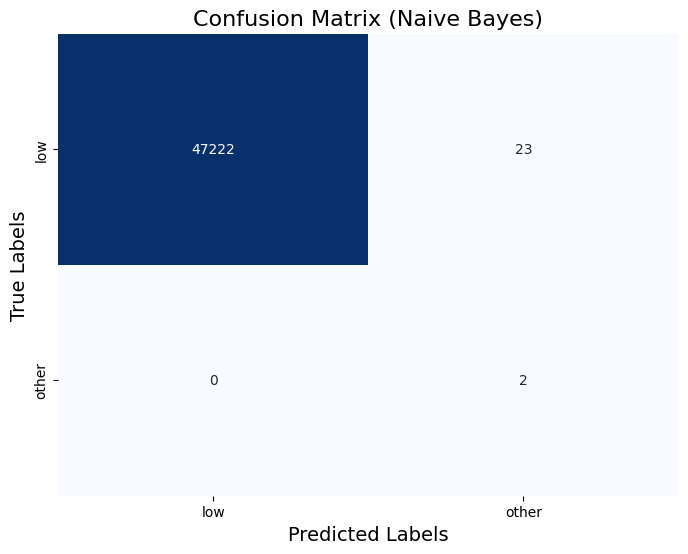

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Merge 'medium' and 'high' into a single class ---
y_merged = y_binned.replace({'medium': 'other', 'high': 'other'})

# --- Split Data into Train and Test Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y_merged, test_size=0.2, random_state=42)

# --- Train Naive Bayes ---
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# --- Predict on Test Data ---
y_pred = nb_model.predict(X_test)

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred)

# --- Visualize Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix (Naive Bayes)', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()


**END**